In [141]:
import glob
import re
import json 
import itertools
import functools 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rc('font', family='Arial', size=12)

In [138]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

def mean_95_ci(ax, mat, x = None, color='blue', **mean_kws):
    if x is None:
        x = np.arange(0, mat.shape[1], 1, **mean_kws)
    ax.plot(x, mat.mean(axis=0), color=color)
    ax.fill_between(x, 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

In [2]:
mats = glob.glob('../../genome_correlations/histone_tss/*.temp')

In [3]:
sample_extractor = re.compile('/([^/]+)\.temp')

In [4]:
filename_correspondence = {i: sample_extractor.findall(i)[0] for i in mats}

In [5]:
experiment_metadata = pd.read_csv('/Volumes/Pegasus/shared_files/public_data/histone/histone_metadata.tsv', sep='\t')

In [6]:
accession_to_target = (experiment_metadata
                      .set_index('File accession')
                      [['Experiment target']]
                      .to_dict()['Experiment target'])

In [7]:
target_to_accessions = {}
for accession, target in accession_to_target.items():
    if accession not in filename_correspondence.values():
        continue
    if target in target_to_accessions:
        target_to_accessions[target].append(accession)
    else:
        target_to_accessions[target] = [accession]

In [8]:
target_to_accessions

{'H2AFZ-human': ['ENCFF751ZDZ', 'ENCFF817TSN', 'ENCFF642VOB'],
 'H3K27ac-human': ['ENCFF856TEC', 'ENCFF407CRM', 'ENCFF194XTD'],
 'H3K27me3-human': ['ENCFF707MDT',
  'ENCFF288GDB',
  'ENCFF772IJJ',
  'ENCFF435XFF',
  'ENCFF353ZNI',
  'ENCFF614HNF'],
 'H3K36me3-human': ['ENCFF181RGC', 'ENCFF726HYM', 'ENCFF521FCP'],
 'H3K4me1-human': ['ENCFF285WCS', 'ENCFF355QUC', 'ENCFF430ZMK'],
 'H3K4me2-human': ['ENCFF868OIN', 'ENCFF922JIZ', 'ENCFF752UST'],
 'H3K4me3-human': ['ENCFF517GGF',
  'ENCFF413XSQ',
  'ENCFF489CIY',
  'ENCFF592JVE',
  'ENCFF098COW',
  'ENCFF913SUG',
  'ENCFF045UGB',
  'ENCFF934QDA',
  'ENCFF509ECR'],
 'H3K79me2-human': ['ENCFF945TVZ', 'ENCFF728FKC', 'ENCFF303MHF'],
 'H3K9ac-human': ['ENCFF060ZMW', 'ENCFF087ZDM', 'ENCFF431ISH'],
 'H3K9me3-human': ['ENCFF650BSN', 'ENCFF946DLG', 'ENCFF891XLY'],
 'H4K20me1-human': ['ENCFF557LCN', 'ENCFF408GTM', 'ENCFF324PJA']}

In [9]:
overlapped_tss = pd.read_csv('../../genome_correlations/histone_tss/tss_overlap.bed', sep='\t', names=('chr', 'start', 'end', 'gencode'))

In [10]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str), 
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

In [14]:
histone_data = {}
for filename, samplename in filename_correspondence.items():
        histone_data[samplename] = read_matrix_file(filename)

In [15]:
len(histone_data)

42

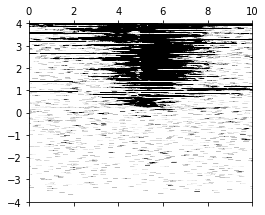

In [16]:
plt.matshow(histone_data['ENCFF045UGB'].iloc[np.argsort(histone_data['ENCFF045UGB'].mean(axis=1))[::-1], :], 
            extent = [0, 10, -4 ,4], cmap = 'Greys', vmin=0, vmax=5 )

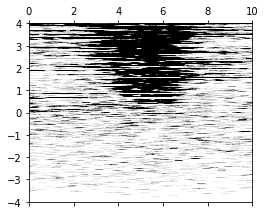

In [17]:
plt.matshow(histone_data['ENCFF060ZMW'].iloc[np.argsort(histone_data['ENCFF060ZMW'].mean(axis=1))[::-1], :], 
            extent = [0, 10, -4 ,4], cmap = 'Greys', vmin=0, vmax=5 )

In [18]:
genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/HeLa_expression/Hela_expressed_full_genes.bed',
                    sep = '\t', names = ('chr', 'start', 'end', 'name', 'value', 'strand')
                   )

In [19]:
genes.head()

,chr,start,end,name,value,strand
0,chr1,11868,14409,ENST00000456328.2,5,+
1,chr1,14403,29570,ENST00000488147.1,928,-
2,chr1,29553,31097,ENST00000473358.1,20,+
3,chr1,34553,36081,ENST00000417324.1,11,-
4,chr1,89294,120932,ENST00000466430.5,72,-


In [20]:
r_loop_sites = pd.read_csv('../../genome_correlations/histone_tss/tss_overlap.bed', sep='\t',
                           names = ('chr', 'start', 'end', 'name')
                          )

In [61]:
r_loop_sites = r_loop_sites.merge(genes[['name', 'value']])

In [62]:
non_r_loop = genes[~genes.name.isin(r_loop_sites.name)]

In [65]:
def closest_L2_pairs(needles, haystack):
    n_needles = needles.shape[0]
    n_haystack = haystack.shape[0]
    dists = np.zeros((n_needles, n_haystack))
    dists = np.sqrt((dists.T + np.sum(np.square(needles), axis=1)).T + np.sum(np.square(haystack), axis=1) - 2* needles.dot(haystack.T))
    return dists


In [87]:
closest_idx = np.abs(r_loop_sites.value.as_matrix() - non_r_loop.value.as_matrix().reshape(1, len(non_r_loop)).T)

In [88]:
closest_idx

array([[  32, 2329,  265, ..., 2116,  120,  228],
       [ 891, 1406,  658, ..., 1193,  803,  695],
       [  17, 2314,  250, ..., 2101,  105,  213],
       ...,
       [  22, 2275,  211, ..., 2062,   66,  174],
       [  93, 2204,  140, ..., 1991,    5,  103],
       [  50, 2247,  183, ..., 2034,   38,  146]])

In [90]:
mins = closest_idx.argmin(axis=1)
used_elements = set()
pairs = []

for i in range(closest_idx.shape[0]):
    if mins[i] not in used_elements:
        pairs.append((i, mins[i], closest_idx[i, mins[i]]))
        used_elements.add(mins[i])
    else:
        j = 2
        next_best = np.argsort(closest_idx[i , :])
        while closest_idx[i, next_best[j]] in used_elements:
            j += 1
        pairs.append((i, next_best[j], closest_idx[i, next_best[j]]))

In [93]:
pairs = pd.DataFrame(pairs, columns=('r_loop_idx', 'matched_idx', 'value'))

In [95]:
matched = non_r_loop.iloc[pairs.matched_idx, :]

In [98]:
matched_idx = ucsc_index(genes[genes.name.isin(matched.name)])

In [106]:
read_counts = experiment_metadata.set_index('File accession').Size.to_dict()

In [168]:
mean_by_target = {}

for target, accessions in target_to_accessions.items():
    mean_by_target[target] = [histone_data[accession] for accession in accessions]

In [169]:
means = {k: sum(v)/len(v) for k,v in mean_by_target.items()}

In [170]:
loop_sites_boot = {}
for target, mat in means.items():
    loop_sites_boot[target] = bootstrap_samples(mat.loc[mat.index.isin(r_loop_idx)].as_matrix(), 5000, verbose=True, sample_name = target)

H3K4me3-human 0.0
H3K4me3-human 4.0
H3K4me3-human 8.0
H3K4me3-human 12.0
H3K4me3-human 16.0
H3K4me3-human 20.0
H3K4me3-human 24.0
H3K4me3-human 28.000000000000004
H3K4me3-human 32.0
H3K4me3-human 36.0
H3K4me3-human 40.0
H3K4me3-human 44.0
H3K4me3-human 48.0
H3K4me3-human 52.0
H3K4me3-human 56.00000000000001
H3K4me3-human 60.0
H3K4me3-human 64.0
H3K4me3-human 68.0
H3K4me3-human 72.0
H3K4me3-human 76.0
H3K4me3-human 80.0
H3K4me3-human 84.0
H3K4me3-human 88.0
H3K4me3-human 92.0
H3K4me3-human 96.0
H3K36me3-human 0.0
H3K36me3-human 4.0
H3K36me3-human 8.0
H3K36me3-human 12.0
H3K36me3-human 16.0
H3K36me3-human 20.0
H3K36me3-human 24.0
H3K36me3-human 28.000000000000004
H3K36me3-human 32.0
H3K36me3-human 36.0
H3K36me3-human 40.0
H3K36me3-human 44.0
H3K36me3-human 48.0
H3K36me3-human 52.0
H3K36me3-human 56.00000000000001
H3K36me3-human 60.0
H3K36me3-human 64.0
H3K36me3-human 68.0
H3K36me3-human 72.0
H3K36me3-human 76.0
H3K36me3-human 80.0
H3K36me3-human 84.0
H3K36me3-human 88.0
H3K36me3-human 92

In [171]:
match_sites_boot = {}
for target, mat in means.items():
    match_sites_boot[target] = bootstrap_samples(mat.loc[mat.index.isin(matched_idx)].as_matrix(), 5000, verbose=True, sample_name = target)                           

H3K4me3-human 0.0
H3K4me3-human 4.0
H3K4me3-human 8.0
H3K4me3-human 12.0
H3K4me3-human 16.0
H3K4me3-human 20.0
H3K4me3-human 24.0
H3K4me3-human 28.000000000000004
H3K4me3-human 32.0
H3K4me3-human 36.0
H3K4me3-human 40.0
H3K4me3-human 44.0
H3K4me3-human 48.0
H3K4me3-human 52.0
H3K4me3-human 56.00000000000001
H3K4me3-human 60.0
H3K4me3-human 64.0
H3K4me3-human 68.0
H3K4me3-human 72.0
H3K4me3-human 76.0
H3K4me3-human 80.0
H3K4me3-human 84.0
H3K4me3-human 88.0
H3K4me3-human 92.0
H3K4me3-human 96.0
H3K36me3-human 0.0
H3K36me3-human 4.0
H3K36me3-human 8.0
H3K36me3-human 12.0
H3K36me3-human 16.0
H3K36me3-human 20.0
H3K36me3-human 24.0
H3K36me3-human 28.000000000000004
H3K36me3-human 32.0
H3K36me3-human 36.0
H3K36me3-human 40.0
H3K36me3-human 44.0
H3K36me3-human 48.0
H3K36me3-human 52.0
H3K36me3-human 56.00000000000001
H3K36me3-human 60.0
H3K36me3-human 64.0
H3K36me3-human 68.0
H3K36me3-human 72.0
H3K36me3-human 76.0
H3K36me3-human 80.0
H3K36me3-human 84.0
H3K36me3-human 88.0
H3K36me3-human 92

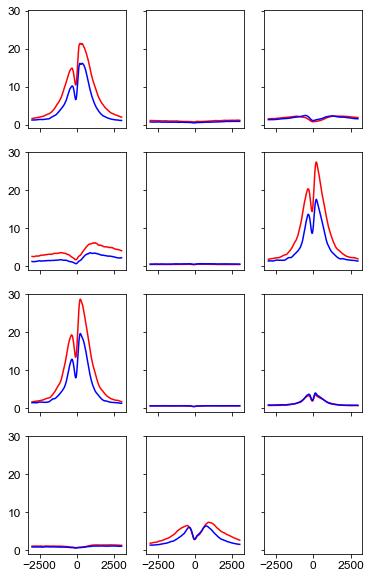

In [172]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, (target, mat) in enumerate(means.items()):
    curr_ax = ax[i // 3, i % 3]
    curr_ax.plot(np.arange(-3000, 3000, 10), 
                 mat.loc[mat.index.isin(r_loop_idx)].mean(axis=0),
                 color = 'red'
                )
    curr_ax.plot(np.arange(-3000, 3000, 10), 
                 mat.loc[mat.index.isin(matched_idx)].mean(axis=0),
                 color = 'blue'
                )



    

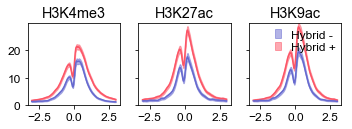

In [184]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7.5 * (3/4), 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K4me3', 'H3K27ac', 'H3K9ac']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] , color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] , color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_title(target.replace('-human', ''))
    curr_ax.set_ylim(0, 30)
    curr_ax.set_yticks([0, 10, 20])
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['Hybrid -', 'Hybrid +']
ax[2].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_diff.svg', transparent=True)

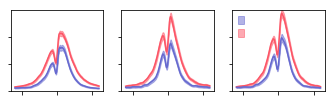

In [186]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7.5 * (3/4), 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K4me3', 'H3K27ac', 'H3K9ac']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] , color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] , color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_ylim(0, 30)
    curr_ax.set_yticks([0, 10, 20])
    curr_ax.set_xticklabels([''] * 3)
    curr_ax.set_yticklabels([''] * 3)
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['      ', '        ']
ax[2].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_diff_unnanotated.svg', transparent=True)

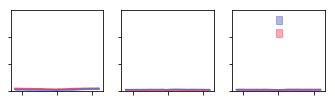

In [187]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7.5 * (3/4), 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K36me3', 'H3K27me3', 'H3K9me3']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] , color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] , color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_ylim(0, 30)
    curr_ax.set_yticks([0, 10, 20])
    curr_ax.set_xticklabels([''] * 3)
    curr_ax.set_yticklabels([''] * 3)
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['      ', '        ']
ax[2].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_no_diff_unnanotated.svg', transparent=True)

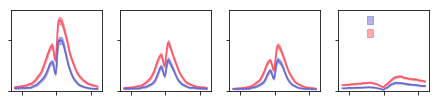

In [164]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(7.5, 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K4me3', 'H3K27ac', 'H3K9ac', 'H3K79me2']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] * 1e6, color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] * 1e6, color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_ylim(0, 0.08)
    curr_ax.set_yticks([0.0, 0.05])
    curr_ax.set_yticklabels([''] * 2)
    curr_ax.set_xticklabels([''] * 2)
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['           ', '            ']
ax[3].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_diff_unannotated.svg', transparent=True)

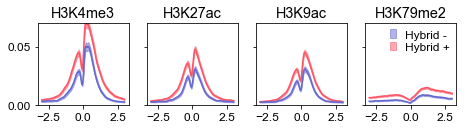

In [158]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(7.5, 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K4me3', 'H3K27ac', 'H3K9ac', 'H3K79me2']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] * 1e6, color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] * 1e6, color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_title(target.replace('-human', ''))
    curr_ax.set_ylim(0, 0.07)
    curr_ax.set_yticks([0.0, 0.05])
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['Hybrid -', 'Hybrid +']
ax[3].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_no_diff.svg', transparent=True)

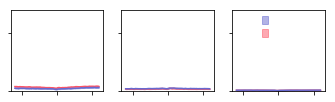

In [167]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7.5 * (3/4), 1.5))

up_color, down_color =  '#fc5566', '#6669cf'

for i, target in enumerate([i+'-human' for i in ['H3K36me3', 'H3K27me3', 'H3K9me3']]):
    curr_ax = ax[i]
    mean_95_ci( curr_ax, loop_sites_boot[target] * 1e6, color=up_color, x=np.arange(-3, 3, 0.01), label='Hybrid +')
    mean_95_ci(curr_ax, match_sites_boot[target] * 1e6, color=down_color, x=np.arange(-3, 3, 0.01), label ='Hybrid -')
    curr_ax.set_ylim(0, 0.07)
    curr_ax.set_yticks([0.0, 0.05])
    curr_ax.set_yticklabels([''] * 2)
    curr_ax.set_xticklabels([''] * 2)
    
handles = [
mpl.patches.Patch(color = down_color, alpha = 0.5),
mpl.patches.Patch(color = up_color, alpha = 0.5),
]
labels = ['           ', '            ']
ax[2].legend(handles, labels, frameon=False, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
fig.savefig('histone_no_diff_unnanotated.svg', transparent=True)

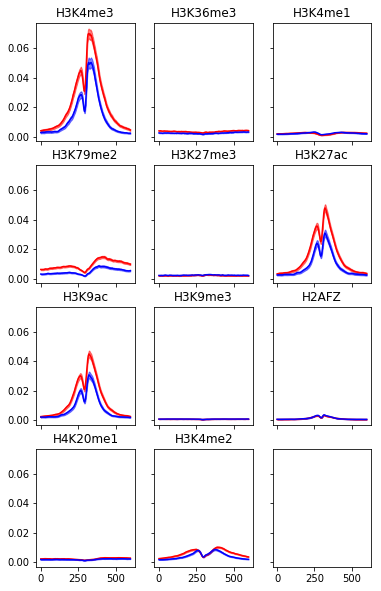

In [132]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, target in enumerate(means):
    curr_ax = ax[i // 3, i % 3]
    mean_95_ci( curr_ax, loop_sites_boot[target] * 1e6, color='red')
    mean_95_ci(curr_ax, match_sites_boot[target] * 1e6, color='blue')
    curr_ax.set_title(target.replace('-human', ''))
    

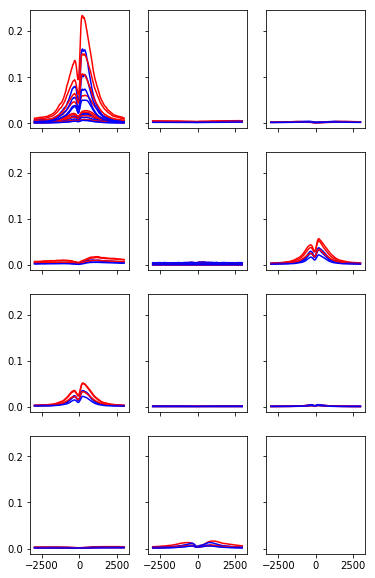

In [109]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, (target, accessions) in enumerate(target_to_accessions.items()):
    curr_ax = ax[i // 3, i % 3]
    for accession in accessions:
        read_count = read_counts[accession]/1e6
        curr_ax.plot(np.arange(-3000, 3000, 10), 
                     histone_data[accession].loc[histone_data[accession].index.isin(r_loop_idx)].mean(axis=0)/read_count,
                     color = 'red'
                    )
        curr_ax.plot(np.arange(-3000, 3000, 10), 
             histone_data[accession].loc[histone_data[accession].index.isin(matched_idx)].mean(axis=0)/read_count,
             color = 'blue'
            )
        

    

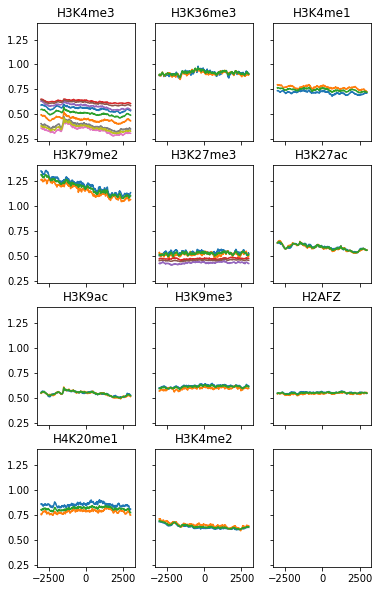

In [38]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, (target, accessions) in enumerate(target_to_accessions.items()):
    curr_ax = ax[i // 3, i % 3]
    for accession in accessions:
        curr_ax.plot(np.arange(-3000, 3000, 10), histone_data[accession].loc[histone_data[accession].index.isin(gene_body_peaks)].mean(axis=0))
        curr_ax.set_title(target.replace('-human', ''))

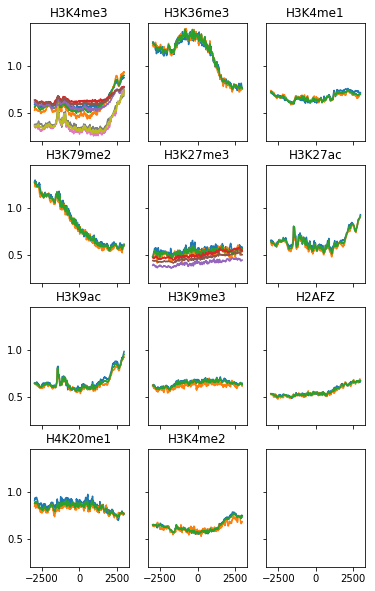

In [39]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, (target, accessions) in enumerate(target_to_accessions.items()):
    curr_ax = ax[i // 3, i % 3]
    for accession in accessions:
        curr_ax.plot(np.arange(-3000, 3000, 10), histone_data[accession].loc[histone_data[accession].index.isin(terminator_peaks)].mean(axis=0))
        curr_ax.set_title(target.replace('-human', ''))

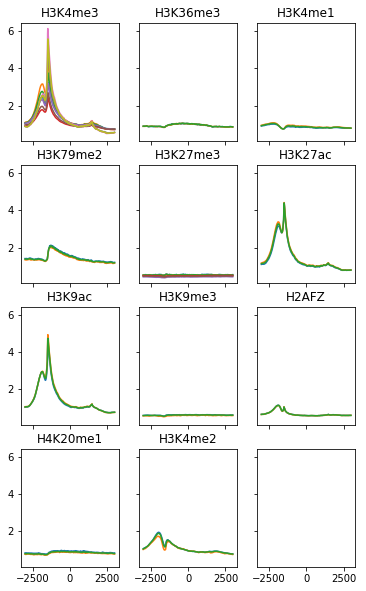

In [40]:
fig, ax = plt.subplots(ncols = 3, nrows =4, figsize=(6,10), sharex=True, sharey=True)

for i, (target, accessions) in enumerate(target_to_accessions.items()):
    curr_ax = ax[i // 3, i % 3]
    for accession in accessions:
        curr_ax.plot(np.arange(-3000, 3000, 10), histone_data[accession].mean(axis=0))
        curr_ax.set_title(target.replace('-human', ''))

In [64]:
target_to_accessions['H3K27ac-human']

['ENCFF856TEC', 'ENCFF407CRM', 'ENCFF194XTD']